Image dir: /kaggle/input/crop-3000
Price file: /kaggle/input/raichur-allcrops-priceweather-sorted-xlsx/Raichur_AllCrops_PriceWeather_Sorted.xlsx
Train images: 2528, Validation images: 632
Using device for crop-id: cuda
Epoch 1/10 | Loss=0.3987 | Train Acc=83.43% | Val Acc=90.66%
Epoch 2/10 | Loss=0.1693 | Train Acc=92.76% | Val Acc=92.41%
Epoch 3/10 | Loss=0.1456 | Train Acc=93.47% | Val Acc=93.83%
Epoch 4/10 | Loss=0.1117 | Train Acc=95.61% | Val Acc=94.46%
Epoch 5/10 | Loss=0.0794 | Train Acc=96.24% | Val Acc=92.56%
Epoch 6/10 | Loss=0.0546 | Train Acc=97.67% | Val Acc=94.46%
Epoch 7/10 | Loss=0.0408 | Train Acc=98.73% | Val Acc=95.25%
Epoch 8/10 | Loss=0.0351 | Train Acc=98.69% | Val Acc=95.73%
Epoch 9/10 | Loss=0.0350 | Train Acc=98.77% | Val Acc=95.09%
Epoch 10/10 | Loss=0.0347 | Train Acc=98.73% | Val Acc=95.89%
Saved ResNet model to resnet_crop_model_improved.pth


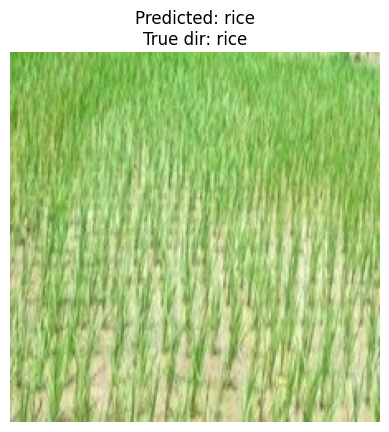

Identified crop: rice
Price file columns: ['Date', 'District', 'Crop', 'Price (INR/quintal)', 'Temperature (°C)', 'Humidity (%)', 'Rainfall (mm)']
Using price column: Price (INR/quintal)
Using series from 2020-01-01 to 2024-12-01 (60 months)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - loss: 0.4079 - mae: 0.5771 - val_loss: 0.1710 - val_mae: 0.3726
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.3143 - mae: 0.4890 - val_loss: 0.1074 - val_mae: 0.2736
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2210 - mae: 0.4010 - val_loss: 0.0619 - val_mae: 0.1699
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1488 - mae: 0.3239 - val_loss: 0.0364 - val_mae: 0.1294
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1098 - mae: 0.2777 - val_loss: 0.0407 - val_mae: 0.1977
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0855 - mae: 0.2506 - val_loss: 0.0788 - val_mae: 0.2644
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0986 - mae: 0.2530 - val_loss: 0.0981 - val_mae: 0.2855
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1102 - mae: 0.2657 - val_loss: 0.0761 - val_mae: 0.2605
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0932 - mae: 0.2538 -

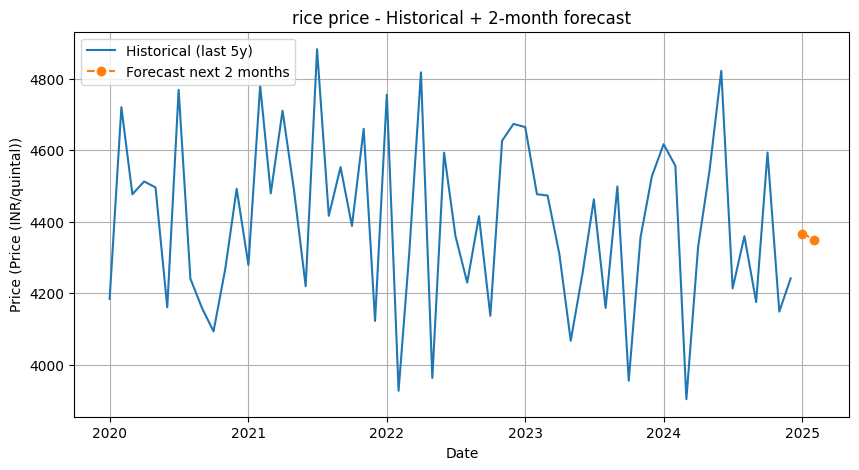

In [20]:
# ============================================================
# MERGED PIPELINE: ResNet50 (PyTorch) crop-id  +  LSTM (Keras) price forecast
# Uses price file:
# /kaggle/input/raichur-allcrops-priceweather-sorted-xls/Raichur_AllCrops_PriceWeather_Sorted.xls
# ============================================================

import os
import random
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch for crop-id
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from PIL import Image

# TensorFlow/Keras for forecasting
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# ----------------------------
# SETTINGS (change if needed)
# ----------------------------
IMAGE_DATA_DIR = "/kaggle/input/crop-3000"   # your image dataset
PRICE_FILE = "/kaggle/input/raichur-allcrops-priceweather-sorted-xlsx/Raichur_AllCrops_PriceWeather_Sorted.xlsx"

# Crop-id training params
BATCH_SIZE = 32
EPOCHS = 10
IMG_SIZE = 224
LR = 1e-4
# Ensure these correspond to your folder names in crop-3000 (lowercase/trimmed)
class_names = ['maize', 'rice', 'wheat']
NUM_CLASSES = len(class_names)

# Forecast params
WINDOW_SIZE = 12       # months of history
FORECAST_HORIZON = 2   # predict 2 months forward
LSTM_UNITS = 64
DROPOUT = 0.2
TF_EPOCHS = 10
TF_BATCH = 16
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# ----------------------------
# Quick checks
# ----------------------------
if not os.path.exists(IMAGE_DATA_DIR):
    raise FileNotFoundError(f"Image directory not found: {IMAGE_DATA_DIR}")
if not os.path.exists(PRICE_FILE):
    raise FileNotFoundError(f"Price file not found: {PRICE_FILE}")

print("Image dir:", IMAGE_DATA_DIR)
print("Price file:", PRICE_FILE)

# ----------------------------
# Transforms (same as your code)
# ----------------------------
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.RandomAffine(15, shear=10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ----------------------------
# Load images and create dataloaders
# ----------------------------
full_dataset = datasets.ImageFolder(IMAGE_DATA_DIR, transform=train_transform)
val_size = int(len(full_dataset) * 0.2)
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
# Ensure validation uses the val transform
val_dataset.dataset.transform = val_test_transform

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f"Train images: {len(train_dataset)}, Validation images: {len(val_dataset)}")

# ----------------------------
# Build and fine-tune ResNet50
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device for crop-id:", device)

model = models.resnet50(weights="IMAGENET1K_V1")
# Freeze all except last block and fc
for name, param in model.named_parameters():
    param.requires_grad = ("layer4" in name or "fc" in name)
# Replace fc
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Training loop (lightweight, uses EPOCHS variable)
for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total if total>0 else 0.0
    train_loss = running_loss / total if total>0 else 0.0

    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    val_acc = 100 * val_correct / val_total if val_total>0 else 0.0

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss={train_loss:.4f} | Train Acc={train_acc:.2f}% | Val Acc={val_acc:.2f}%")
    scheduler.step()

# Save the trained ResNet model
torch.save(model.state_dict(), "resnet_crop_model_improved.pth")
print("Saved ResNet model to resnet_crop_model_improved.pth")

# ----------------------------
# Random image prediction (inference)
# ----------------------------
# Build list of images to choose from (inside IMAGE_DATA_DIR)
all_images = []
for root, _, files in os.walk(IMAGE_DATA_DIR):
    for f in files:
        if f.lower().endswith(('.jpg', '.jpeg', '.png')):
            all_images.append(os.path.join(root, f))
if not all_images:
    raise RuntimeError(f"No images found under {IMAGE_DATA_DIR}")

# reload model for inference
infer_model = models.resnet50(pretrained=False)
infer_model.fc = nn.Linear(infer_model.fc.in_features, NUM_CLASSES)
infer_model.load_state_dict(torch.load("resnet_crop_model_improved.pth", map_location=device))
infer_model = infer_model.to(device)
infer_model.eval()

def predict_random_image():
    img_path = random.choice(all_images)
    true_dir = os.path.basename(os.path.dirname(img_path))
    img = Image.open(img_path).convert("RGB")
    input_img = val_test_transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = infer_model(input_img)
        _, pred = torch.max(out, 1)
        predicted_crop = class_names[pred.item()]
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_crop}\nTrue dir: {true_dir}")
    plt.show()
    return predicted_crop

predicted_crop = predict_random_image()
print("Identified crop:", predicted_crop)

# ----------------------------
# PRICE FORECASTING (Keras LSTM)
# ----------------------------
# Read price Excel (use xlrd engine for .xls)
try:
    df_price = pd.read_excel(PRICE_FILE, engine='xlrd')
except Exception as e:
    print("Warning: read_excel with engine='xlrd' failed:", e)
    # fallback to default engine if xlrd not available
    df_price = pd.read_excel(PRICE_FILE)

print("Price file columns:", list(df_price.columns))

# Normalize column names and ensure Date parsed

df_price['Date'] = pd.to_datetime(df_price['Date'], errors='coerce')
if df_price['Date'].isnull().any():
    raise ValueError("Some dates could not be parsed. Fix date format in Excel.")

# Find price column automatically
price_cols = [c for c in df_price.columns if 'price' in c.lower()]
if not price_cols:
    raise ValueError("No column with 'price' found in the price file.")
price_col = price_cols[0]
print("Using price column:", price_col)

# Helper: prepare monthly price series for crop
def prepare_monthly_series(df, crop_name):
    dfc = df.copy()
    dfc['Crop_clean'] = dfc['Crop'].astype(str).str.strip().str.lower()
    target = crop_name.strip().lower()
    # prefer exact match
    if target in dfc['Crop_clean'].unique():
        sel = dfc[dfc['Crop_clean'] == target]
    else:
        sel = dfc[dfc['Crop_clean'].str.contains(target, na=False)]
    if sel.empty:
        raise ValueError(f"No rows found for crop '{crop_name}'. Available sample crops: {df['Crop'].unique()[:20]}")
    sel = sel.sort_values('Date')
    sel['Month'] = sel['Date'].values.astype('datetime64[M]')
    monthly = sel.groupby('Month')[price_col].mean().sort_index()
    monthly.index = pd.to_datetime(monthly.index)
    monthly = monthly.asfreq('MS')  # ensure monthly frequency
    monthly = monthly.interpolate(method='time').ffill().bfill()
    return monthly.rename('Price')

# Build series for predicted crop
monthly = prepare_monthly_series(df_price, predicted_crop)
# restrict to last 5 years
last_date = monthly.index.max()
five_yrs_ago = last_date - pd.DateOffset(years=5)
monthly_5y = monthly[monthly.index >= five_yrs_ago]
if len(monthly_5y) < WINDOW_SIZE + 2:
    print(f"Warning: Not enough points in last 5 years ({len(monthly_5y)}). Using whole series.")
    monthly_5y = monthly.copy()

print(f"Using series from {monthly_5y.index.min().date()} to {monthly_5y.index.max().date()} ({len(monthly_5y)} months)")

# Prepare sequences
values = monthly_5y.values.reshape(-1, 1).astype('float32')
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)

def create_sequences(arr, window):
    X, y = [], []
    for i in range(len(arr) - window):
        X.append(arr[i:i+window])
        y.append(arr[i+window])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled, WINDOW_SIZE)
if X.shape[0] < 4:
    raise ValueError("Not enough sequences to train LSTM. Try smaller WINDOW_SIZE or more data.")

# Build Keras LSTM
def build_lstm(window, units=LSTM_UNITS, dropout=DROPOUT):
    model = Sequential()
    model.add(LSTM(units, input_shape=(window,1), return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

tf_model = build_lstm(WINDOW_SIZE)
tf_model.summary()

# Train/val split: last 10% for val
val_split = max(1, int(0.1 * len(X)))
train_X, val_X = X[:-val_split], X[-val_split:]
train_y, val_y = y[:-val_split], y[-val_split:]

history = tf_model.fit(train_X, train_y, validation_data=(val_X, val_y),
                       epochs=TF_EPOCHS, batch_size=TF_BATCH, verbose=1)

# Iterative forecast
last_window = scaled[-WINDOW_SIZE:].reshape(1, WINDOW_SIZE, 1).astype('float32')
preds_scaled = []
cur = last_window.copy()
for step in range(FORECAST_HORIZON):
    p = tf_model.predict(cur, verbose=0)[0,0]
    preds_scaled.append(p)
    cur = np.append(cur.flatten()[1:], p).reshape(1, WINDOW_SIZE, 1)

preds_scaled = np.array(preds_scaled).reshape(-1,1)
preds_unscaled = scaler.inverse_transform(preds_scaled).flatten()

# Forecast dates
last_mon = monthly_5y.index.max()
forecast_months = [last_mon + pd.DateOffset(months=i+1) for i in range(FORECAST_HORIZON)]

# Output
print("\n--- 2-Month Forecast ---")
for dt, price in zip(forecast_months, preds_unscaled):
    print(f"{predicted_crop} predicted price on {dt.date()}: ₹{price:.2f} per quintal")

out_df = pd.DataFrame({"Date": forecast_months, "Predicted_Price_INR_per_quintal": preds_unscaled})
csv_name = f"forecast_{predicted_crop.replace(' ', '_')}.csv"
out_df.to_csv(csv_name, index=False)
print("Saved forecast CSV:", csv_name)

# Plot
plt.figure(figsize=(10,5))
plt.plot(monthly_5y.index, monthly_5y.values, label='Historical (last 5y)')
plt.plot(forecast_months, preds_unscaled, marker='o', linestyle='--', label=f'Forecast next {FORECAST_HORIZON} months')
plt.title(f"{predicted_crop} price - Historical + {FORECAST_HORIZON}-month forecast")
plt.xlabel("Date")
plt.ylabel(f"Price ({price_col})")
plt.legend()
plt.grid(True)
png_name = f"forecast_{predicted_crop.replace(' ', '_')}.png"
plt.savefig(png_name, bbox_inches='tight', dpi=150)
print("Saved forecast plot:", png_name)
plt.show()



================= RESULT =================
🌾 Identified Crop      : Rice
🔄 Price Crop (Mapped)  : Sona masoori rice
📌 Model Confidence     : 100.0%


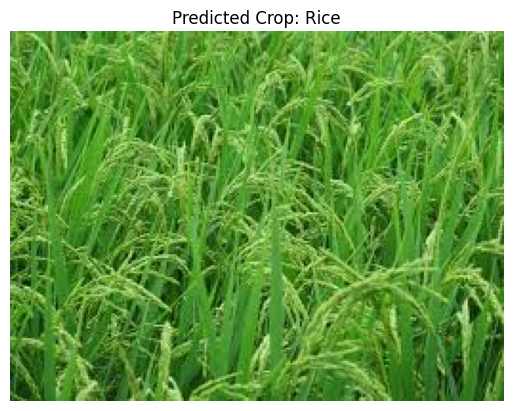


📈 NEXT 2 MONTH PRICE FORECAST
----------------------------------------
   Jan 2025 : ₹4407.13 / quintal
   Feb 2025 : ₹4389.34 / quintal



In [17]:
# ============================================================
# SINGLE IMAGE PIPELINE:
# Crop Identification (ResNet50) + Price Forecast (LSTM)
# Clean Output – NO GRAPH
# ============================================================

import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt


# PyTorch
import torch
from torchvision import transforms, models
import torch.nn.functional as F

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# -------------------------------------------------------------
# SETTINGS
# -------------------------------------------------------------
PRICE_FILE = "/kaggle/input/raichur-allcrops-priceweather-sorted-xlsx/Raichur_AllCrops_PriceWeather_Sorted.xlsx"
MODEL_PATH = "resnet_crop_model_improved.pth"

IMG_SIZE = 224
class_names = ['maize', 'rice', 'wheat']
NUM_CLASSES = len(class_names)

WINDOW_SIZE = 12
FORECAST_HORIZON = 2
LSTM_UNITS = 64
DROPOUT = 0.2
TF_EPOCHS = 15
TF_BATCH = 16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------------------------------------------
# 1️⃣ LOAD RESNET50 MODEL
# -------------------------------------------------------------
model = models.resnet50(weights=None)       # ← fixed deprecation warning
model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model = model.to(device)
model.eval()

# Image transform
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# -------------------------------------------------------------
# 2️⃣ CROP IDENTIFICATION
# -------------------------------------------------------------
image_path = "/kaggle/input/test-image2/images.jpg"   # ← YOUR IMAGE PATH

image = Image.open(image_path).convert("RGB")
img_tensor = transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(img_tensor)
    probs = F.softmax(outputs, dim=1)
    conf, pred = torch.max(probs, 1)

predicted_crop = class_names[pred.item()]
confidence = conf.item() * 100

# -------------------------------------------------------------
# 3️⃣ CROP NAME MAPPING
# -------------------------------------------------------------
CROP_MAP = {
    "rice": "sona masoori rice",
    "maize": "maize",
    "wheat": "wheat"
}

mapped_crop = CROP_MAP[predicted_crop]

# -------------------------------------------------------------
# 4️⃣ LOAD PRICE DATA
# -------------------------------------------------------------
df = pd.read_excel(PRICE_FILE)

df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Date"])

# Find correct price column
price_cols = [c for c in df.columns if "price" in c.lower()]
price_col = price_cols[0]

# Clean text
df["Crop_clean"] = df["Crop"].astype(str).str.lower().str.strip()
target_crop = mapped_crop.lower().strip()

# Filter only needed crop
df_crop = df[df["Crop_clean"] == target_crop].copy()

if df_crop.empty:
    raise ValueError(f"No price data found for crop: {mapped_crop}")

df_crop = df_crop.sort_values("Date")
df_crop["Month"] = df_crop["Date"].values.astype("datetime64[M]")

# Monthly average prices
monthly = df_crop.groupby("Month")[price_col].mean().sort_index()
monthly.index = pd.to_datetime(monthly.index)
monthly = monthly.asfreq("MS").interpolate().ffill().bfill()

# -------------------------------------------------------------
# 5️⃣ LSTM FORECAST
# -------------------------------------------------------------
values = monthly.values.reshape(-1, 1).astype("float32")

scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)

def create_sequences(arr, win):
    X, Y = [], []
    for i in range(len(arr) - win):
        X.append(arr[i:i + win])
        Y.append(arr[i + win])
    return np.array(X), np.array(Y)

X, y = create_sequences(scaled, WINDOW_SIZE)

model_lstm = Sequential([
    LSTM(LSTM_UNITS, input_shape=(WINDOW_SIZE, 1)),
    Dropout(DROPOUT),
    Dense(1)
])

model_lstm.compile(optimizer="adam", loss="mse")
model_lstm.fit(X, y, epochs=TF_EPOCHS, batch_size=TF_BATCH, verbose=0)

# Forecast next 2 months
window = scaled[-WINDOW_SIZE:].reshape(1, WINDOW_SIZE, 1)
pred_scaled = []

for i in range(FORECAST_HORIZON):
    p = model_lstm.predict(window, verbose=0)[0, 0]
    pred_scaled.append(p)
    window = np.append(window.flatten()[1:], p).reshape(1, WINDOW_SIZE, 1)

forecast_values = scaler.inverse_transform(
    np.array(pred_scaled).reshape(-1, 1)
).flatten()

last_date = monthly.index[-1]
forecast_dates = [last_date + pd.DateOffset(months=i + 1) for i in range(FORECAST_HORIZON)]

# -------------------------------------------------------------
# 6️⃣ CLEAN OUTPUT ONLY
# -------------------------------------------------------------

print("\n================= RESULT =================")
print(f"🌾 Identified Crop      : {predicted_crop.capitalize()}")
print(f"🔄 Price Crop (Mapped)  : {mapped_crop.capitalize()}")
print(f"📌 Model Confidence     : {confidence:.1f}%")
plt.imshow(image)
plt.axis("off")
plt.title(f"Predicted Crop: {predicted_crop.capitalize()}")
plt.show()

print("\n📈 NEXT 2 MONTH PRICE FORECAST")
print("----------------------------------------")
for d, v in zip(forecast_dates, forecast_values):
    print(f"   {d.strftime('%b %Y')} : ₹{v:.2f} / quintal")

print("==========================================\n")


In [16]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
